# Online GC Calibration
The prupose of calibrating an on-line GC is to be able to use it to obtain quantitative concentration data for you gas stream.
In order to do so, a calibration gas (mixture) is injected onto the GC. This allows us to get the relationship between the peak area and the concentration in the bottle. 
Note that when calibrating a 'conventional' GC you inject samples with different concentraiton, allowing to establish a proper resposne factor. Since we generally only use one bottle, we are effectively doing single point calibrations, and often rely on a plethora of other assumptions, what we are doing is not 'fine analytic chemistry'.
The most important reason why you should calibrate is to account for drift in the detectors between experiments overer longer pereiods of time. I have seen differences of 10% between calibrations a year appart, so take this into consideration when comparing experiemtns. 
Below i will provide examples for the calibration of two different GC systems:
- The MTO setup
- The 'big' pyGCMS

# MTO setup

For details regarding the processing of data from the on-line GC setup check the dedicated Notebook.
Here we use a bottle with components from Methane to Pentane as well as Hydrogen diluted by Nitrogen.

In [56]:
from chromstream.objects import Experiment
from chromstream.data_processing import time_window_baseline
from pathlib import Path
import pandas as pd
import chromstream.parsers as csp
import matplotlib.pyplot as plt

In [57]:
data_home = Path("..")/"dev_data" / "chroms" /  "MTO_calibration"
paths_all = sorted((data_home).iterdir())
# Initialize an Experiment
exp_mto = Experiment("MTO_calib")

for path in paths_all:
    Chrom1, Chrom2, Chrom3 = csp.parse_MTO_asc(path)
    # Applying baseline (mean in a specified time window)
    Chrom1.apply_baseline(time_window_baseline, time_window=(288,294),inplace=True)
    Chrom2.apply_baseline(time_window_baseline, time_window=(288,294),inplace=True)
    Chrom3.apply_baseline(time_window_baseline, time_window=(10,15),inplace=True)
    # Adding chromatograms to the experiment
    exp_mto.add_chromatogram(Chrom1)
    exp_mto.add_chromatogram(Chrom2)
    exp_mto.add_chromatogram(Chrom3)

Briefly plotting the chromatograms:

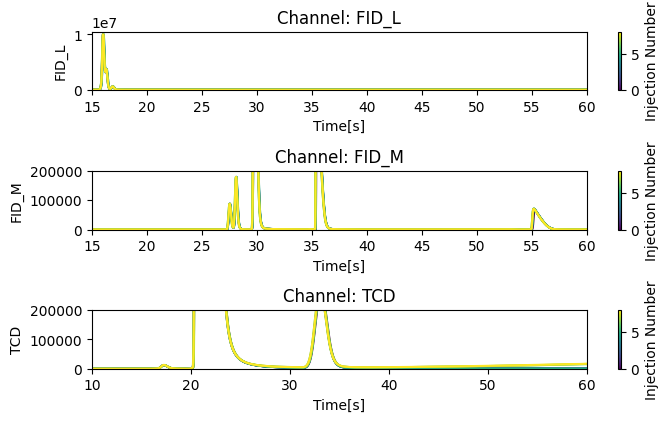

In [72]:
fig, axs = plt.subplots(3,1, figsize=(7,7/1.618))
exp_mto.plot_chromatograms(ax=axs)
plt.tight_layout()
axs[0].set_ylim(-100000,)
axs[0].set_xlim(15,60)

axs[1].set_xlim(15,60)
axs[1].set_ylim(0,200000)

axs[2].set_ylim(0,200000)
axs[2].set_xlim(10,60)
plt.show()

As you can see we have 5 peaks (5 hydrocarbons) on the middle FID colum, on the 'long' FID columns the compunds are not seperated. On the TCD channel, we see a clearly saturated Nirogen peak, as well as a small hydrogen peak.

Next, we define the peaks we want to integrate:

In [59]:
Peaks_FID_L = {
    'All_FID_L': [15, 18]
}
Peaks_FID_M = {
    'Pentane': [54, 58],
    'Butane': [34, 38],
    'Propane': [29, 34],
    'Ethane': [27.87, 29.26],
    'Methane': [27.5, 27.87],
    'ALL_products_FID_M': [26, 150]
}

Peaks_TCD = {
    'N2': [20, 26],
    'H2': [16, 19]
}


We do the integration for each channel:

In [60]:
integrals_FID_L = exp_mto.channels['FID_L'].integrate_peaks(peaklist=Peaks_FID_L,).drop(columns=['Timestamp'])
integrals_FID_M = exp_mto.channels['FID_M'].integrate_peaks(peaklist=Peaks_FID_M,).drop(columns=['Timestamp'])
integrals_TCD = exp_mto.channels['TCD'].integrate_peaks(peaklist=Peaks_TCD,).drop(columns=['Timestamp'])

peak_areas = pd.concat([integrals_FID_L, integrals_FID_M, integrals_TCD], axis=1)

We do a quick plot to see if some injections deviate signifcantly from the rest.

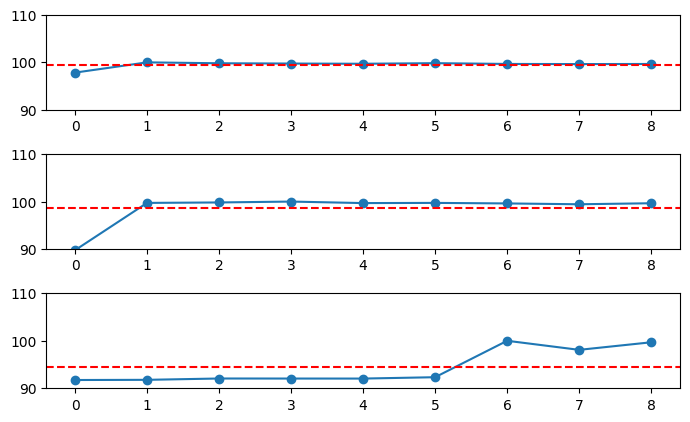

In [61]:
Fig, axs = plt.subplots(3,1, figsize=(7,7/1.618))
axs[0].plot(peak_areas.index, peak_areas['All_FID_L']/peak_areas['All_FID_L'].max()*100, 'o-')
axs[0].axhline(peak_areas['All_FID_L'].mean()/peak_areas['All_FID_L'].max()*100, color='r', linestyle='--')

axs[1].plot(peak_areas.index, peak_areas['ALL_products_FID_M']/peak_areas['ALL_products_FID_M'].max()*100, 'o-')
axs[1].axhline(peak_areas['ALL_products_FID_M'].mean()/peak_areas['ALL_products_FID_M'].max()*100, color='r', linestyle='--')

axs[2].plot(peak_areas.index, peak_areas['H2']/peak_areas['H2'].max()*100, 'o-')
axs[2].axhline(peak_areas['H2'].mean()/peak_areas['H2'].max()*100, color='r', linestyle='--')


for ax in axs:
    ax.set_ylim(90,110)
plt.tight_layout()
plt.show()

We throw out the first two and look at the mean and std dev. The the errors are too large, it could be an issue with the baseline, the peak boundries or the measurement itself.
In our case, the larger devaition for the methane peak is likely due to the poor seperation from the Ethane peak. For the other peaks, we have deviations significantly below 1%.

In [62]:
peak_areas_red = peak_areas.iloc[2:] 
# check mean, std and the relative std

results = peak_areas_red.describe(include='all').T[['mean','std']]
results['rel_std(%)'] = results['std']/results['mean']*100
results = results.sort_values('rel_std(%)')
print(results)

                            mean           std  rel_std(%)
N2                  1.974884e+07  13188.784646    0.066783
All_FID_L           3.357269e+06   2514.523884    0.074898
Pentane             6.163667e+04     97.134246    0.157592
Butane              2.726687e+05    434.329830    0.159288
Propane             6.391794e+05   1026.447373    0.160588
ALL_products_FID_M  1.045433e+06   1848.405804    0.176808
Ethane              4.610635e+04    221.736694    0.480924
H2                  1.009140e+04    409.497726    4.057888
Methane             1.500512e+04   1616.426102   10.772500


The concentrations of our calibration bottle are determined in vol%. To get a single-point calibration factor for each species, we divide the concentration by the peak area:
\begin{equation}
    CF_{vol\%} = \dfrac{c_{vol\%}}{A_{peak}}
\end{equation}

Depending the unit you need, you can first convert vol% into the unit you need. For this you can use e.g. the ideal gas law, just keep in mind its limiations.

In [63]:
bottle_content = pd.DataFrame(columns=['vol_pct'],index=['Pentane','Butane','Propane','Ethane','Methane'])
bottle_content['vol_pct'] = [0.535,2.97,9.16,0.971,1.003]
bottle_content['C_atoms'] = [5,4,3,2,1]
# for the middle channel
CF_mid = {component: (bottle_content['vol_pct'][component]/results['mean'].loc[component]) for component in bottle_content.index}
print(CF_mid)

{'Pentane': np.float64(8.67989760139967e-06), 'Butane': np.float64(1.0892340099713024e-05), 'Propane': np.float64(1.4330874864512388e-05), 'Ethane': np.float64(2.1060004047011747e-05), 'Methane': np.float64(6.684386895558995e-05)}


Mutliplying the calibration factor above with the peak area will return the concentration in vol %.
We can check how much the FID respnse changes between the molecules by accounting for the carbon number:

In [64]:
CF_per_C_atom = {component: (bottle_content['vol_pct'][component]/(results['mean'].loc[component]/bottle_content['C_atoms'][component])) for component in bottle_content.index}

cf_per_c_atom_df = pd.DataFrame.from_dict(CF_per_C_atom, orient='index', columns=['CF_per_C_atom'])
print(cf_per_c_atom_df)

         CF_per_C_atom
Pentane       0.000043
Butane        0.000044
Propane       0.000043
Ethane        0.000042
Methane       0.000067


As you can see the FID response per carbon atom is largely similar, with the exemption of Methane.

But what if you want to analyze a compound for which you dont have a calibration mixture? In this case you can make an estimation of the concetration from the otehr compounds. In my particular use case, i wanted to get the partial pressure of 2-4 dimethyl-pentane specifically from the FID_L channel. One approach would be to determine the CF depending on the carbon number, and then extrapolate to the 7 carbon atoms of my molecule. However, as you could see in the chromatograms above, we cant really seperate the compounds on this channel. 

To still be able to get an **estimation** of the the partial pressure, we simply determine the total concentration of carbon atoms in the gas mixture als follows:
- we assume the ideal gas law holds, i.e. the vol% proporional to n%, i.e. the 
- The signal is perfectly proportial to the carbon number

In [65]:
# We determine the molar concentartion (dividing by 100) and then get the number of carbon atoms by multiplying with the carbon number
bottle_content['n(molecule)*CN'] = bottle_content['vol_pct']/100*bottle_content['C_atoms']
# the total concentartion of carbon atoms in the gas mixture
sum_n_CN = bottle_content['n(molecule)*CN'].sum()
# Getting the sigal per carbon atom by deviding by the total signal
CF_CN = sum_n_CN / results.loc['All_FID_L','mean']

print(f"Calibration factor per carbon atom: {CF_CN} ")

Calibration factor per carbon atom: 1.3397794275617057e-07 


When this calibration factor is multiplied by the peak area, and devided by the number of carbon atoms in the molecule, the vol % is obtained
\begin{equation}
    c_{vol\%} = \dfrac{CF_{CN} \cdot A_{peak}}{CN}
\end{equation}

Where CN is the carbon number of the molecule.


## pyGCMS